<a href="https://colab.research.google.com/gist/qbeer/1df46c5028ad976dcf497f8117046830/hw9_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural networks, introduction


### 1. Implement a logistic regression model on MNIST for binary classification in Numpy

* use `from sklearn.datasets import load_digits`
  * the provided data files: X_train, X_test are a split generated by the author of this exercise
  * w, b are the fitted logistic regression weight and bias, the predictions on the provided test set can be generated by: `y_pred_test = sigmoid(np.dot(w, X_test.T) + b)`
  * the binarized accuracy score should be above 98% for this particular data
* divide the data into 0 vs. 1-9. categories
  * the goal is to separate the zeros
* y = logistic(wx + b)
* optimize the model via stochastic mini-batch gradient descent until you reach above 90% accuracy on the test set

* the loss:

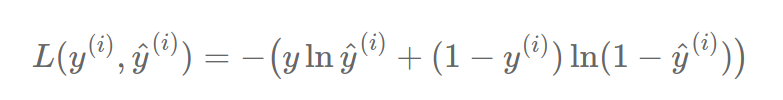

* the gradients of the mini-batch loss:

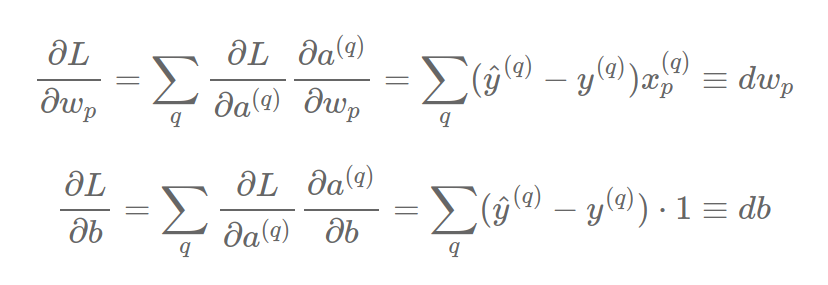



For some reason, this task does not add up in my head, so I had to look at different solutions! Of course, this exact solution is not in them!

Is there anything specific about the classification? 

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py


Logistic regression:

https://machinelearningmastery.com/implement-logistic-regression-stochastic-gradient-descent-scratch-python/


In [1]:
import numpy as np
import pandas as pd

import math

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os 
import pathlib
import glob

from sklearn.datasets import load_digits

In [3]:
digits = load_digits()
print(digits.data.shape)

(1797, 64)


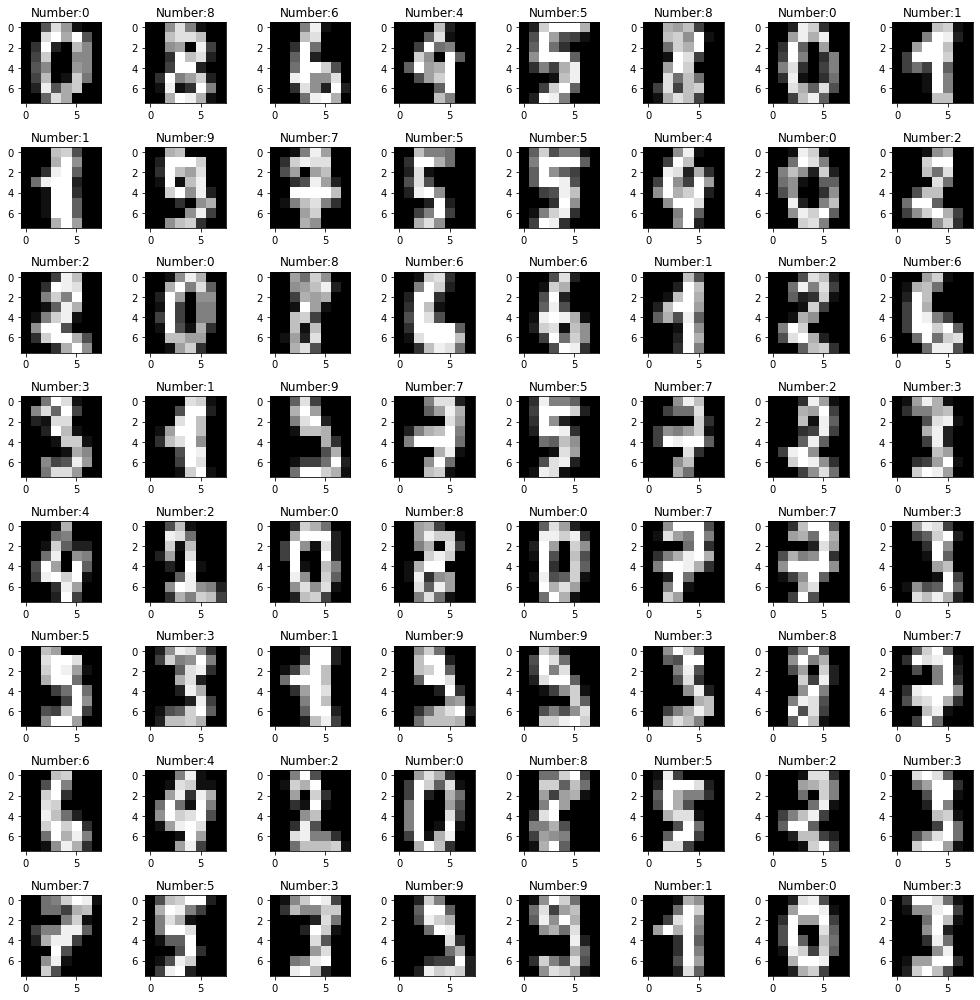

In [13]:
nrows=8
ncols=8

fig, ax = plt.subplots(nrows,ncols,figsize=(14,14))

for i in range(ncols):
    for j in range(nrows):
        image = digits.images[i+j*ncols]
        ax[i,j].imshow(image, cmap="gray", interpolation="nearest")
        ax[i,j].set_title("Number:{0}".format(digits.target[i+j*ncols]))

fig.tight_layout()        
plt.show()

Just a couple of NOTEs!

[1] The data is the same as the images, but it is flattened 

[2] I will use the data for prediction

In [10]:
digits.images[1]

array([[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
       [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
       [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

Let's implement a mini-batch gradient descent!

In [18]:
def sigmoid(value):
    return 1/(1+np.exp(-x))


def predit(X,y):
    """
    Predicting values
    
    INPUT:
        X: input values for the prediction
        y: input values for the fit
    OUTPUT:
        y_pred: prediction with logistic regressinon
    """
    return sigmoid(np.dot(w, X_test.T) + b)


def minibatch_gradient_descent(X,y,theta,learning_rate=0.01,iterations=10, batch_size=20):
    """
    Mini-batch descent with shuffle and (almost) logistic regression burned in.
    
    INPUT:
        X: input values for fitting, ARRAY
        y: target values for logistic regression, ARRAY
        theta: coef collector for random start, ARRAY
        learning_rate
        iterations: number of iterations, INT
        batch_size: size of batch, INT
    OUTPUT
        theta: finalized coefs
        cost_history: cost history for the fit
    
    """
    m = len(y)
    cost_history = np.zeros(iterations)
    n_batches = int(m / batch_size)
    for it in range(iterations):
        cost=0.0
        
        #shuffle
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        
        for i in range(0,m,batch_size):
            X_i = X[i:i+batch_size]
            y_i = y[i:i+batch_size]
            X_i = np.c_[np.ones(len(X_i)), X_i]
            prediction = np.dot(X_i, theta)                                       #this has to be changed for y_pred_test
            theta = theta - (1/m)*learning_rate*(X_i.T.dot((prediction - y_i)))   #this has to be changed for b
                                                                                  #additional row for all the other coeffs
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it] = cost
    return theta, cost_history

In [16]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

### 2. MLP model in `tf.keras`

* implement a model as such:

 * 750 neuron, relu activation
 * 500 neuron, relu activation
 * 500 neuron, relu activation
 * 10 neuron, softmax activation

* use the `tf.keras.datasets.mnist` dataset in this case
* preprocess if necessary
* use the 'sgd' optimizer, log the loss ('categorical_crossentropy') and the accuracy, as well as the AUC score during training, visualize the history of these values



### 3. Evaluation

* confusion matrix on the test set
* visualize mistakes (at least 16) in a grid, show the true and the predicted labels
* plot the ROC curve for each predicted class



### 4. Come up with your own model

* come up with your own small model (< 100'000 neurons)
* train it for 50 epochs
* visualize the loss for train/test on the same plot
  * what are your thoughs on the phenomenon?
* plot the ROC curves and the AUC scores



### 5. Experiment with the CIFAR10 dataset

* preprocess the data, modify the models accordingly
  * train your small model as well as the model in the 3rd task on the CIFAR10 dataset
* compare the results
* are these models powerful enough to fit this data?




Hints:

On total you can get 10 points for fully completing all tasks.

Decorate your notebook with, questions, explanation etc, make it self contained and understandable!

Comments you code when necessary

Write functions for repetitive tasks!

Use the pandas package for data loading and handling

Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation

Use the scikit learn package for almost everything

Use for loops only if it is really necessary!

Code sharing is not allowed between student! Sharing code will result in zero points.

If you use code found on web, it is OK, but, make its source clear!
